# GAN with CelebA

### 1. Kaggle 데이터셋 다운로드

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuuunjin","key":"bd342e3fa43d323694af95869c299d1b"}'}

In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 95% 1.27G/1.33G [00:10<00:01, 41.1MB/s]
100% 1.33G/1.33G [00:10<00:00, 132MB/s] 


### 2. 이미지 전처리

In [4]:
import glob

images = glob.glob("./img_align_celeba/img_align_celeba/*.jpg")
print(len(images))

202599


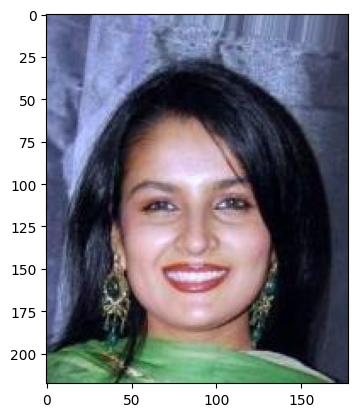

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open("./img_align_celeba/img_align_celeba/005031.jpg")
plt.imshow(image)

In [6]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(
    root="./img_align_celeba/",
    transform=transform
)

data_loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)

tensor(0)


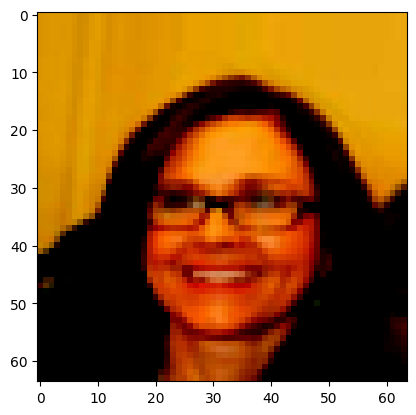

In [8]:
import numpy as np

iter_data = iter(data_loader)
img, label = next(iter(iter_data))

img = img[3].numpy()
print(label[3])
plt.imshow(np.transpose(img, (1, 2, 0)))

### 3. GAN 모델 생성

In [9]:
import torch.nn as nn

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.gen = nn.Sequential(
        nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.gen(x)


In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.disc = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 1, kernel_size=4),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return self.disc(x)

### 4. 모델 학습

In [11]:
def weights_init(m):
  classname = type(m).__name__

  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [12]:
import torch
import tqdm
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

G.apply(weights_init)
D.apply(weights_init)

G_optim = Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
for epoch in range(20):
  iterator = tqdm.tqdm(enumerate(data_loader), total=len(data_loader))

  for idx, data in iterator:
    D_optim.zero_grad()
    label = torch.ones_like(data[1], dtype=torch.float32).to(device)
    label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

    real = D(data[0].to(device))
    D_loss_real = nn.BCELoss()(torch.squeeze(real), label)
    D_loss_real.backward()

    noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
    fake = G(noise)
    output = D(fake.detach())
    D_loss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
    D_loss_fake.backward()

    D_loss = D_loss_real + D_loss_fake
    D_optim.step()

    G_optim.zero_grad()
    output = D(fake)
    G_loss = nn.BCELoss()(torch.squeeze(output), label)
    G_loss.backward()
    G_optim.step()

    iterator.set_description(f"Epoch: {epoch} | D_loss {D_loss}, G_loss {G_loss}")

  torch.save(G.state_dict(), './generator.pt')
  torch.save(D.state_dict(), './discriminator.pt')

Epoch: 0 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:42<00:00,  3.43it/s]
Epoch: 1 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:39<00:00,  3.45it/s]
Epoch: 2 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:38<00:00,  3.45it/s]
Epoch: 3 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:34<00:00,  3.48it/s]
Epoch: 4 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:34<00:00,  3.48it/s]
Epoch: 5 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:34<00:00,  3.49it/s]
Epoch: 6 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:32<00:00,  3.50it/s]
Epoch: 7 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:46<00:00,  3.40it/s]
Epoch: 8 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:46<00:00,  3.39it/s]
Epoch: 9 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:45<00:00,  3.40it/s]
Epoch: 10 | D_loss 100.0, G_loss 0.0: 100%|██████████| 1583/1583 [07:43<00:00,  3.41it/s]
Epoch: 11 | D_loss 1

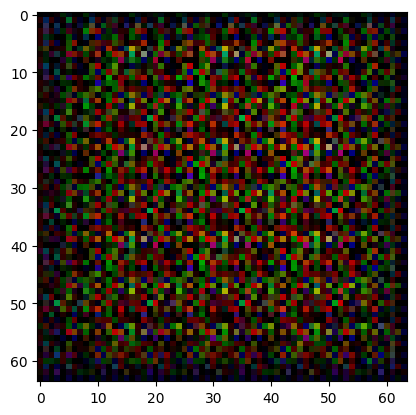

In [19]:
with torch.no_grad():
  G.load_state_dict(torch.load('./generator.pt'))
  noise = torch.randn(1, 100, 1, 1).to(device)
  img = G(noise).squeeze()
  img = img.permute(1, 2, 0).cpu().numpy()
  plt.imshow(img)